# Kriging using a predifined model
In this notebook we will revisite the kriging method for interpolation. For simplicity we will work with a given correlation model. That is, the Whittle Model taken from the FIA data.

So first thing first, import the neessary modules. Depending on your machine this may change.
For the moment I work with this.

In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('/apps/external_plugins/spystats/spystats')
sys.path.append('/apps/external_plugins/spystats')

import django
django.setup()
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')


In [2]:
import pandas as pd
from statsmodels.regression import linear_model
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import statsutils 

In [3]:
import tools
import HEC_runs.fit_fia_logbiomass_logspp_GLS as auxiliary

In [4]:
## File locations, change accordingly
empirical_data_path = "/RawDataCSV/idiv_share/FIA_Plots_Biomass_11092017.csv"
variogram_path = "/apps/external_plugins/spystats/HEC_runs/results/variogram/data_envelope.csv"


## Geographic extent 

In [5]:
minx = -130
maxx = -60
miny = 24
maxy = 50

### Auxiliary functions
    * Open file
    * Convert it to Pandas with Geometry (GeoPandas)
    * Reproject it to Lambert Conic Conformal
    * Calculate OLS and append residuals

In [6]:
data = auxiliary.initAnalysis(empirical_data_path=empirical_data_path,plotdata_path=variogram_path, maxx=maxx,minx=minx,maxy=maxy,miny=miny)

INFO:root:Reading data
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reprojecting to Alberts equal area
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Removing possible duplicates. 
 This avoids problems of Non Positive semidefinite
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Fitting OLS linear model: logBiomass ~ logSppN 
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Subselecting Region


### For testing, subselect the first 50 data points

In [7]:
test_data = data.loc[0:300,:]

## Now lets instantiate the variogram according to the results obtained in the cluster.
Remember:
    < Whittle Variogram : sill 0.340246718396, range 41188.0234423, nugget 0.329937603763, alpha1.12143687914 >

In [8]:
model = tools.WhittleVariogram(sill=0.340246718396,range_a=41188.0234423,nugget=0.329937603763,alpha=1.12143687914)

### Let's see the correlation

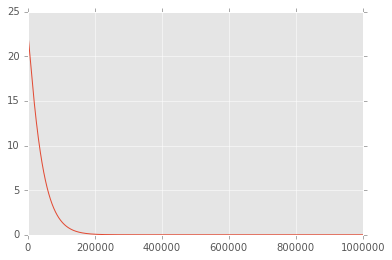

In [9]:
import numpy as np
X = np.linspace(0,1000000,1000)
plt.plot(X,model.corr_f(X))

In [10]:
vg = tools.Variogram(test_data,'residuals',model=model)
MM = vg.calculateCovarianceMatrix()

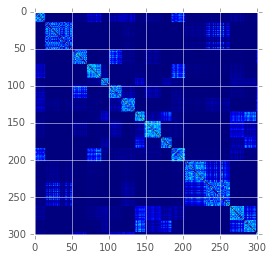

In [11]:
plt.imshow(MM)

### Setting the beta coefficients (obtained earlier) 
Intercept = 8.4704  
logSppN =  0.3909  


In [12]:
#lmod = linear_model.GLS.from_formula(formula='logBiomass ~ logSppN',data=test_data,sigma=MM)

In [13]:
beta = np.array([8.4704,0.3909])

In [14]:
df = data.logSppN
X = [np.ones(len(df)),df.values]
predicted_average = np.dot(beta,X)

In [15]:
predicted_average = np.dot(beta,X)

In [16]:
predicted_average.shape

(36869,)

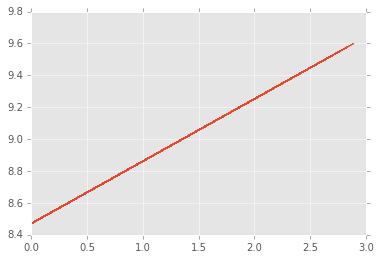

In [17]:
plt.plot(df.values,predicted_average)

## Now it comes the experimentation
Strategy:
* take subsample to start working with it:


In [18]:
minx = -108
maxx = -106
miny = 38
maxy = 40

l =10

section = tools._subselectDataFrameByCoordinates(data,'LON','LAT',minx, maxx, miny, maxy)

In [19]:
section[:4]

,STATECD,STATENM,STATEAB,COUNTYCD,PLOT,PLOT_ID,PlotIDn,LAT,LON,INVYR,...,treeDensity,plotBA,plotBiomass,SppN,geometry,logBiomass,newLon,newLat,logSppN,residuals
4696,8,Colorado,CO,15,80839,8_15_80839,20559,38.802245,-106.327560,2014,...,18,1.578068,5566.572585,2,POINT (-886784.9069972886 194191.0602918091),8.624535,-886784.906997,194191.060292,0.693147,-0.122811
4697,8,Colorado,CO,15,81853,8_15_81853,20566,38.818541,-106.302462,2015,...,10,1.512576,7130.250541,3,POINT (-884440.6792264694 195772.9614230283),8.872102,-884440.679226,195772.961423,1.098612,-0.026912
4698,8,Colorado,CO,15,82088,8_15_82088,20568,38.618958,-106.034139,2015,...,14,1.896535,9669.410421,2,POINT (-863850.243163591 171062.3187071836),9.176723,-863850.243164,171062.318707,0.693147,0.429377
4699,8,Colorado,CO,15,83052,8_15_83052,20572,38.526910,-106.250575,2013,...,31,1.107554,3783.332000,2,POINT (-883522.6144526324 162793.4623146562),8.238360,-883522.614453,162793.462315,0.693147,-0.508985


In [20]:
obsvg = tools.Variogram(section,'residuals',model=model)
MM2= obsvg.calculateCovarianceMatrix()

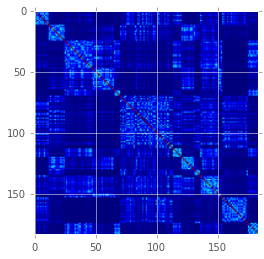

In [21]:
plt.imshow(MM2)

### Read the predictors.
The predictor raster has been calculated using GIS.
The procedure was as follows.
1. rasterize the points of FIA_Biomass adding the values of the points within each cell.
The resolution was 0.03 degrees. for x and y. Approx: 5 km.

2. The raster was converted to csv
3. Loaded into Pandas as predictor.
### Load the predictor data frame

In [22]:
predictors = pd.read_csv("/RawDataCSV/FIA/pred_krig.csv", names = ["Lon", "Lat", "SppN"])
Ypredictors = pd.read_csv("/RawDataCSV/FIA/Ypred_krig.csv", names = ["Lon", "Lat", "Biomass"])


In [23]:
predictors = tools.toGeoDataFrame(predictors,xcoord_name="Lon",ycoord_name="Lat")
## We need to reproject
predictors =  predictors.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

In [24]:
Ypredictors = tools.toGeoDataFrame(Ypredictors,xcoord_name="Lon",ycoord_name="Lat")
Ypredictors['logBiomass'] = np.log(Ypredictors.Biomass)
## Because of how we construct absences we can substitute here all nan by 0.
Ypredictors = Ypredictors.replace(-np.inf,0)
## We need to reproject
#predictors =  predictors.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [25]:
## Do the log of this
predictors['logSppN'] = np.log(predictors.SppN)
## we will have lim x-> 0 log(x) = -inf
## Because of how we construct absences we can substitute here all nan by 0.
predictors = predictors.replace(-np.inf,0)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [26]:
predictors[:10]

,Lon,Lat,SppN,geometry,logSppN
0,-124.684893,49.348905,0,POINT (-2081667.533608335 1636302.653499678),0.0
1,-124.654893,49.348905,0,POINT (-2079556.847067423 1635645.847602986),0.0
2,-124.624893,49.348905,0,POINT (-2077445.953291757 1634989.708038747),0.0
3,-124.594893,49.348905,0,POINT (-2075334.852491694 1634334.234872348),0.0
4,-124.564893,49.348905,0,POINT (-2073223.544877606 1633679.428169104),0.0
5,-124.534893,49.348905,0,POINT (-2071112.030659898 1633025.287994276),0.0
6,-124.504893,49.348905,0,POINT (-2069000.310048988 1632371.814413046),0.0
7,-124.474893,49.348905,0,POINT (-2066888.383255318 1631719.007490536),0.0
8,-124.444893,49.348905,0,POINT (-2064776.250489342 1631066.867291802),0.0
9,-124.414893,49.348905,0,POINT (-2062663.911961547 1630415.393881829),0.0


In [27]:
#Join the dataframes
predictors['logBiomass'] = Ypredictors.logBiomass

In [28]:
[minx,maxx,miny,maxy]

[-108, -106, 38, 40]

In [29]:
def getInnerBlock(pred_df,minx,maxx,miny,maxy):
    # magnitud to shrink
    shrk = 0.5
    shrink = lambda x : x - ( float(x)/abs(x) * shrk )
    shrink_inv = lambda x : x + ( float(x)/abs(x) * shrk )
    mminx = shrink(minx)
    mmaxx = shrink_inv(maxx)
    mminy = shrink_inv(miny)
    mmaxy = shrink(maxy)
    return (mminx,mmaxx,mminy,mmaxy)

In [30]:
exto = [minx,maxx,miny,maxy]
getInnerBlock('dd',*exto)

(-107.5, -106.5, 38.5, 39.5)

In [31]:
nminx,nmaxx,nminy,nmaxy = getInnerBlock('dd',*exto)


In [32]:
pred_section = tools._subselectDataFrameByCoordinates(predictors,'Lon','Lat',nminx, nmaxx, nminy, nmaxy)

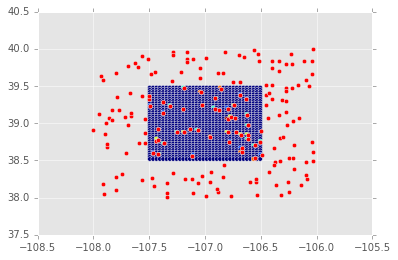

In [33]:
plt.scatter(pred_section.Lon,pred_section.Lat,c=pred_section.SppN)
plt.scatter(section.LON,section.LAT,c='red')

In [34]:
#vg_pred = tools.Variogram(pred_section,'residuals',model=model)
#V = vg_pred.calculateCovarianceMatrix()

In [35]:
#plt.imshow(V)

## Kriging
The minimum mean square error predictor for $S(x)$ is given by:
$$\hat{S}(x) = \mu + r^{'}V^{-1}(Y - \mu)$$
Let's split this accordingly:
* $\mu = \beta X$
* res = (Y - $\mu$)

In [49]:
from scipy.spatial import distance_matrix
obs_px = section.geometry.x
obs_py = section.geometry.y
obs_p = zip(obs_px,obs_py)
obs_p = map(lambda t : np.array(t),obs_p)
## pred
pred_px = pred_section.geometry.x
pred_py = pred_section.geometry.y
pred_p = zip(pred_px,pred_py)
pred_p = map(lambda t : np.array(t),pred_p)

In [57]:
R = distance_matrix(pred_p,obs_p,)

In [62]:
V_inv = np.linalg.inv(MM2)

In [63]:
obsY = section.logBiomass.values
df = section.logSppN
X = [np.ones(len(df)),df.values]
predicted_average = np.dot(beta,X)
obs_res = obsY - predicted_average

In [68]:
partial = np.dot(R,np.dot(V_inv,obs_res))

In [70]:
df = pred_section.logSppN.values
PX = [np.ones(len(df)),df]
pred_mu = np.dot(beta,PX)

In [73]:
Sx = pred_mu + partial

In [74]:
Sx

array([-242914.23005414, -240079.23812162, -235785.83221237, ...,
         23620.00411001,   41088.22643446,   55328.70508047])

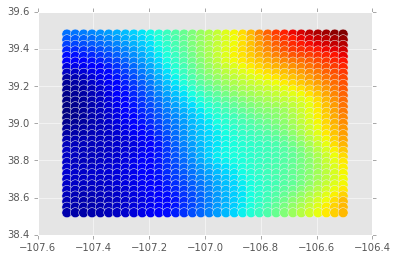

In [75]:
plt.scatter(pred_section.Lon,pred_section.Lat,c=Sx, s=100)
#plt.scatter(section.LON,section.LAT,c='red')

In [ ]:
## Steps
1) Hacer una grid, y predictores (listo)
2) El predictor debe ser presencia ausencia de richeza y talvez usar la suma (listo)
3) generar la matriz extendida
    1. Hacer blockes anidados
    2.  extraer datos y generar matriz
4) Applicar modelo de kriging
5) moverse al siguienate chunck
